In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import yfinance as yf

### Prepare data

In [2]:
start_date = '2024-01-01'
end_date = datetime.datetime.now().strftime('%Y-%m-%d')

tickers = ['COST', 'QBTS', 'GME']
dfs = {}

for ticker in tickers:
    dfs[ticker] = yf.download(ticker, start=start_date, end=end_date).dropna()
    # convert index to datetime
    dfs[ticker].index = pd.DatetimeIndex(dfs[ticker].index)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
dfs['COST'].head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,655.580017,657.799988,649.500000,650.650024,648.653809,2657700
2024-01-03,651.210022,655.450012,643.099976,644.690002,642.712097,2612600
2024-01-04,642.080017,649.900024,640.510010,648.349976,646.360840,2171100
2024-01-05,656.179993,659.650024,652.239990,656.010010,653.997375,2232100
2024-01-08,655.809998,662.080017,654.030029,661.690002,659.659912,2245300


### Check for stationarity: graphically and analytically

In [4]:
# time series plot function
def plot_prices(dfs: dict, plot_columns: list, plot_labels: list, title: str, mean=False, ylabel='Price ($)') -> None:
    fig, axs = plt.subplots(len(dfs), 1, figsize=(12, 3*len(dfs)))
    
    for i, (ticker, df) in enumerate(dfs.items()):
        for column, label in zip(plot_columns, plot_labels):
            axs[i].plot(df[column], label=label)
            # plot mean of dataset
            if mean:
                axs[i].axhline(df[column].mean(), color='r', linestyle='--', label=f'Mean')
                
        axs[i].set_ylabel(ylabel)
        axs[i].set_title(ticker)
        axs[i].legend()
        axs[i].grid()
        
    axs[-1].set_xlabel('Date')
    
    fig.suptitle(title)
    fig.tight_layout()

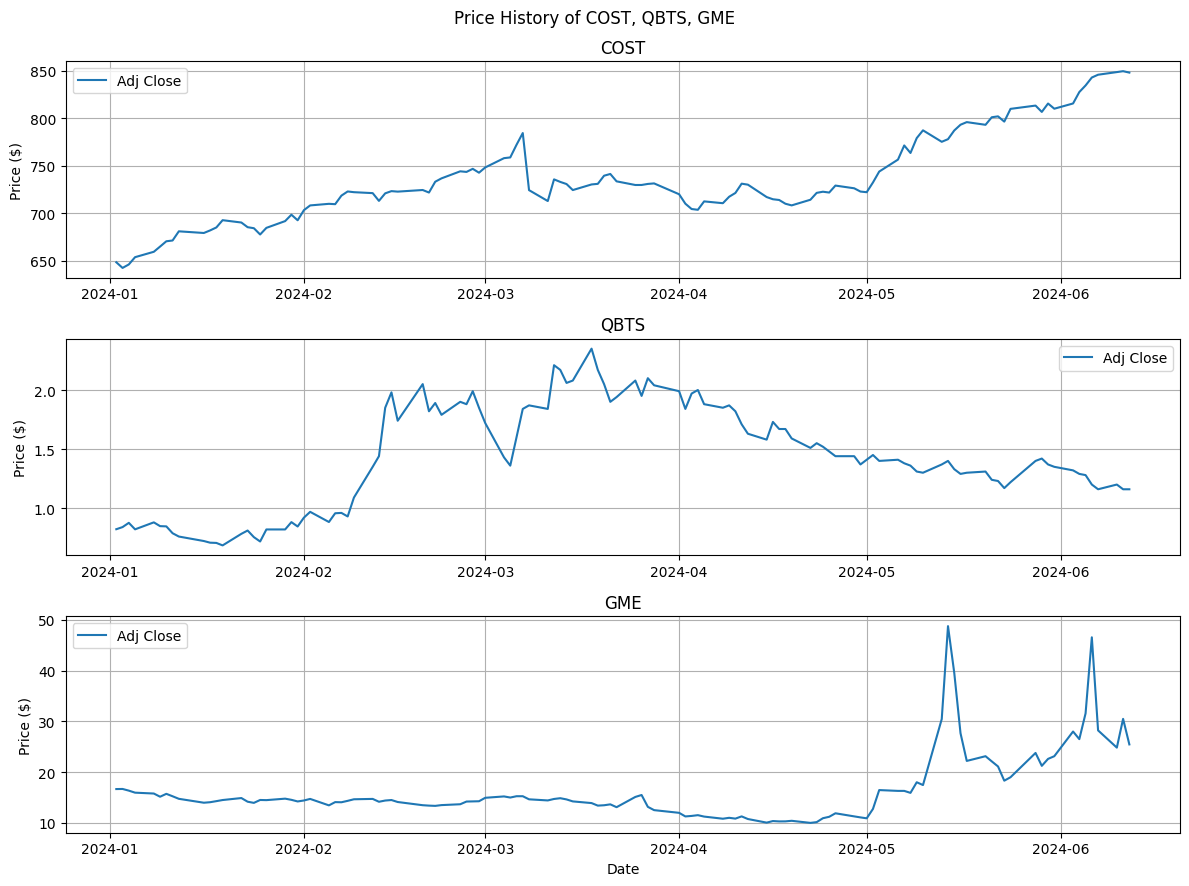

In [5]:
plot_prices(
    dfs, 
    ['Adj Close'], 
    [f'Adj Close'],
    f'Price History of {", ".join(dfs.keys())}'
)

In [6]:
# AD Fuller Test
def adfuller_test(dfs: dict, column: str) -> None:
    for ticker, df in dfs.items():
        result = adfuller(df[column])
        print(f'{ticker}:')
        print(f'ADF Test Statistic: {np.round(result[0], 4)}')
        print(f'p-value: {np.round(result[1], 4)}')
        print(f'Critical Values: {result[4]} \n')

In [7]:
# ADF of the closing price
adfuller_test(dfs, 'Adj Close')

COST:
ADF Test Statistic: -0.1876
p-value: 0.94
Critical Values: {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852} 

QBTS:
ADF Test Statistic: -1.6448
p-value: 0.4598
Critical Values: {'1%': -3.4901313156261384, '5%': -2.8877122815688776, '10%': -2.5807296460459184} 

GME:
ADF Test Statistic: -0.4858
p-value: 0.8947
Critical Values: {'1%': -3.4961490537199116, '5%': -2.8903209639580556, '10%': -2.5821223452518263} 



In [8]:
# take first difference
for ticker in dfs.keys():
    dfs[ticker]['diff'] = dfs[ticker]['Adj Close'].diff()
    dfs[ticker] = dfs[ticker].dropna()

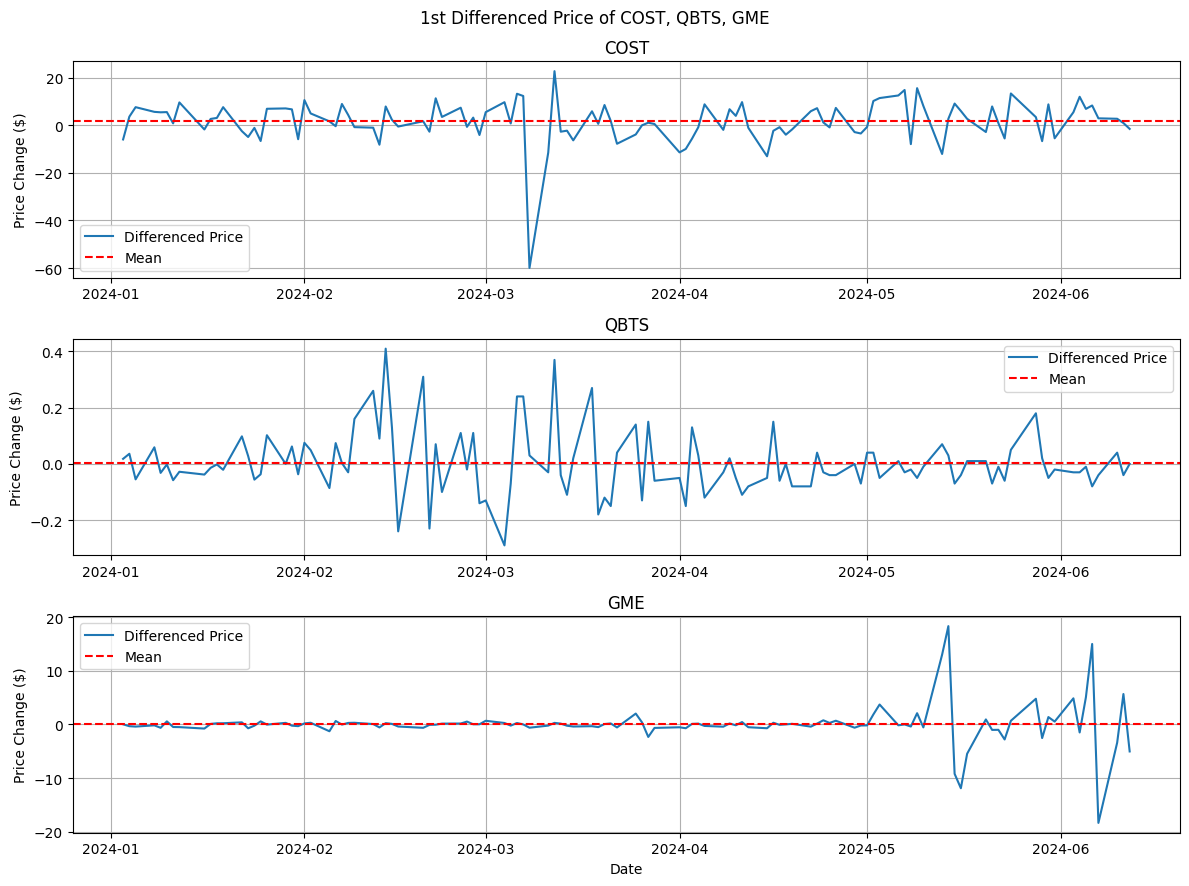

In [9]:
# plot first difference    
plot_prices(
    dfs, 
    ['diff'], 
    ['Differenced Price'],
    f'1st Differenced Price of {", ".join(dfs.keys())}',
    True,
    'Price Change ($)'
)

In [10]:
# ADF of the first difference
adfuller_test(dfs, 'diff')

COST:
ADF Test Statistic: -9.3518
p-value: 0.0
Critical Values: {'1%': -3.4912451337340342, '5%': -2.8881954545454547, '10%': -2.5809876033057852} 

QBTS:
ADF Test Statistic: -10.7205
p-value: 0.0
Critical Values: {'1%': -3.490683082754047, '5%': -2.8879516565798817, '10%': -2.5808574442009578} 

GME:
ADF Test Statistic: -4.8067
p-value: 0.0001
Critical Values: {'1%': -3.4989097606014496, '5%': -2.891516256916761, '10%': -2.5827604414827157} 



### ACF and PACF plots

In [11]:
# ACF, PACF plots
def plot_corr(dfs: dict, plot_column: str, title: str, type: str) -> None:
    fig, axs = plt.subplots(len(dfs), 1, figsize=(12, 3*len(dfs)))
    
    for i, (ticker, df) in enumerate(dfs.items()):
        if type == 'ACF':
            plot_acf(df[plot_column], title=f'{ticker}', ax=axs[i])
        elif type == 'PACF':
            plot_pacf(df[plot_column], title=f'{ticker}', ax=axs[i])
    
    fig.suptitle(title)
    fig.tight_layout()

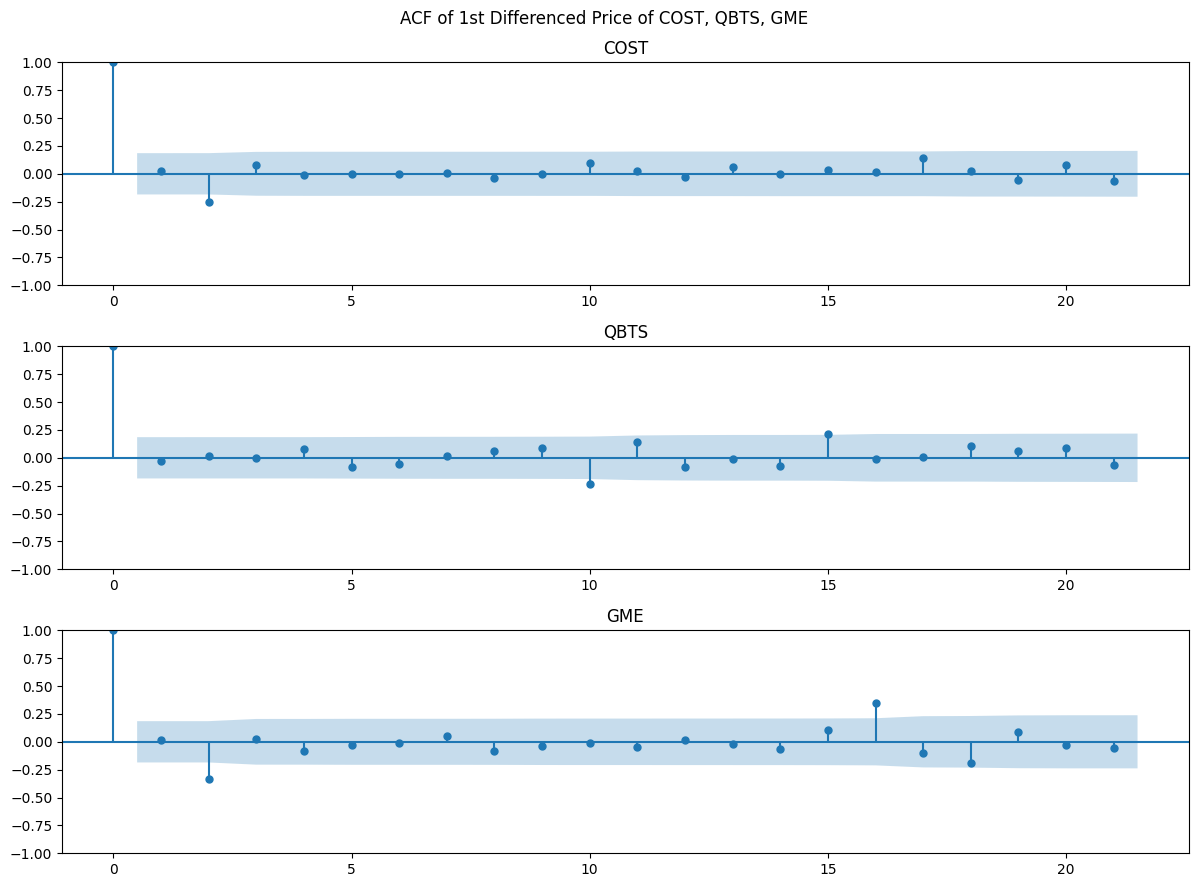

In [12]:
# ACF of 1st differenced price
plot_corr(
    dfs,
    'diff',
    f'ACF of 1st Differenced Price of {", ".join(dfs.keys())}',
    'ACF'
)

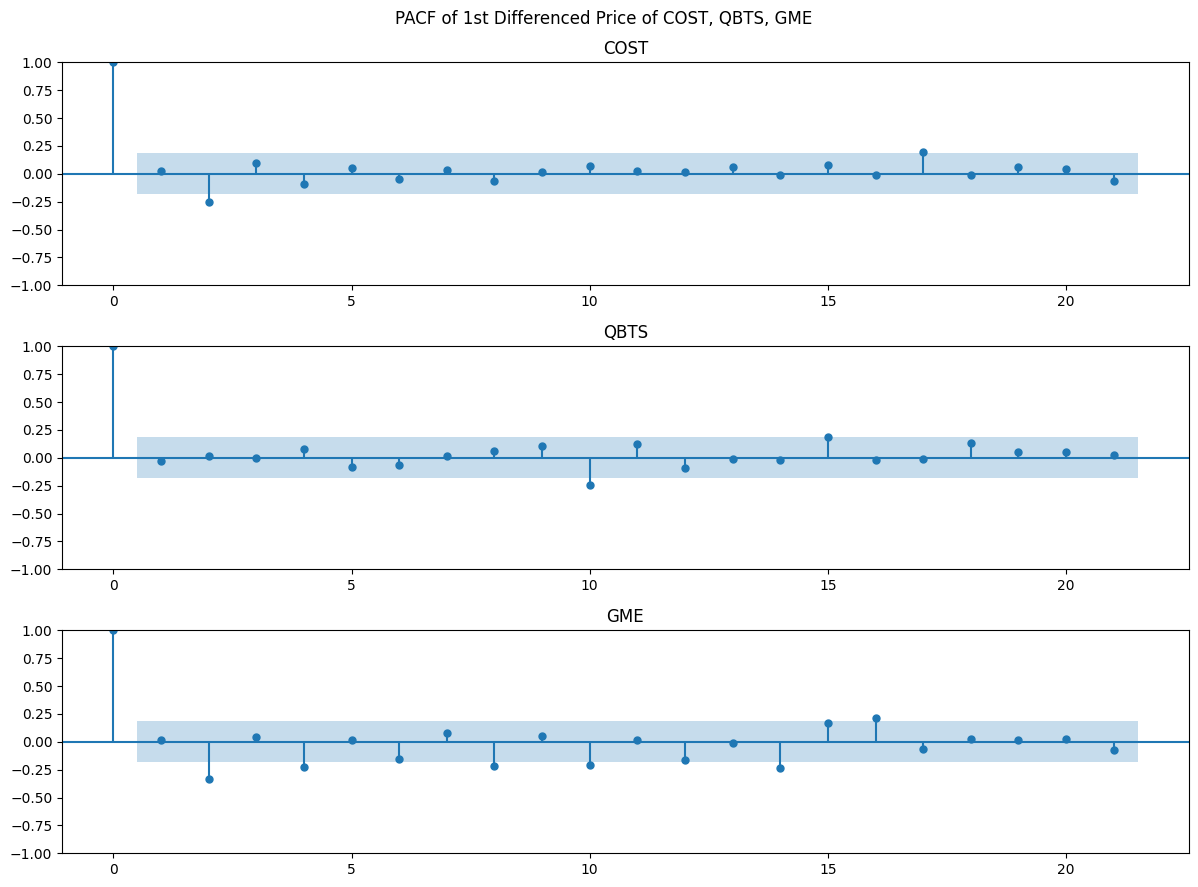

In [13]:
# PACF of 1st differenced price
plot_corr(
    dfs,
    'diff',
    f'PACF of 1st Differenced Price of {", ".join(dfs.keys())}',
    'PACF'
)

### Using AIC and BIC to find best models

In [14]:
# preparing data...
split = 0.7

train_data, test_data = {}, {}

for ticker in tickers:
    train_data[ticker] = pd.DataFrame(
        data={'price': dfs[ticker]['Adj Close'][:int(len(dfs[ticker])*split)]},
        index=dfs[ticker].index[:int(len(dfs[ticker])*split)]
    )
    
    test_data[ticker] = pd.DataFrame(
        data={'price': dfs[ticker]['Adj Close'][int(len(dfs[ticker])*split):]},
        index=dfs[ticker].index[int(len(dfs[ticker])*split):]
    )

In [15]:
# generate candidate model orders
AR = [0, 1, 2, 3, 4, 5]
I = [0, 1, 2]
MA = [0, 1, 2, 3, 4, 5]

model_orders = []
for p in AR:
    for i in I:
        for q in MA:
            model_orders.append((p, i, q))

In [16]:
len(model_orders)

108

In [17]:
models2 = {}
aic = {}
bic = {}

for ticker, df in train_data.items():
    for order in model_orders:
        model = ARIMA(df, order=order)
        fit = model.fit()
        
        models2.setdefault(ticker, []).append(fit)
        aic.setdefault(ticker, []).append(fit.aic)
        bic.setdefault(ticker, []).append(fit.bic)

c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it ha

In [18]:
# min AIC and BIC models
min_aics = {}
min_bics = {}

for ticker in tickers:
    min_aics[ticker] = {
        'value': min(aic[ticker]),
        'index': aic[ticker].index(min(aic[ticker]))
    }
    
    min_bics[ticker] = {
        'value': min(bic[ticker]),
        'index': bic[ticker].index(min(bic[ticker]))
    }


In [19]:
print(f'Min AIC: {min_aics}')
print(f'Min BIC: {min_bics}')

Min AIC: {'COST': {'value': 561.4488270148787, 'index': 15}, 'QBTS': {'value': -92.39939502033938, 'index': 6}, 'GME': {'value': 124.43199941038613, 'index': 8}}
Min BIC: {'COST': {'value': 569.1901630103976, 'index': 6}, 'QBTS': {'value': -90.0555895984857, 'index': 6}, 'GME': {'value': 127.30708407138401, 'index': 6}}


In [20]:
# model orders with min AIC
optimal_orders = {}
for ticker in tickers:
    optimal_orders[ticker] = {
        'Min AIC Model': model_orders[min_aics[ticker]['index']],
        # 'Min BIC Model': model_orders[min_bics[ticker]['index']]
    }

In [21]:
print(f'Optimal Arima Orders: {optimal_orders}')

Optimal Arima Orders: {'COST': {'Min AIC Model': (0, 2, 3)}, 'QBTS': {'Min AIC Model': (0, 1, 0)}, 'GME': {'Min AIC Model': (0, 1, 2)}}


In [22]:
# predictions plot
for ticker in tickers:
    train_data[ticker]['prediction'] = np.array(models2[ticker][min_aics[ticker]['index']].predict().values)
    
    # drop first few rows
    train_data[ticker] = train_data[ticker].iloc[3:]

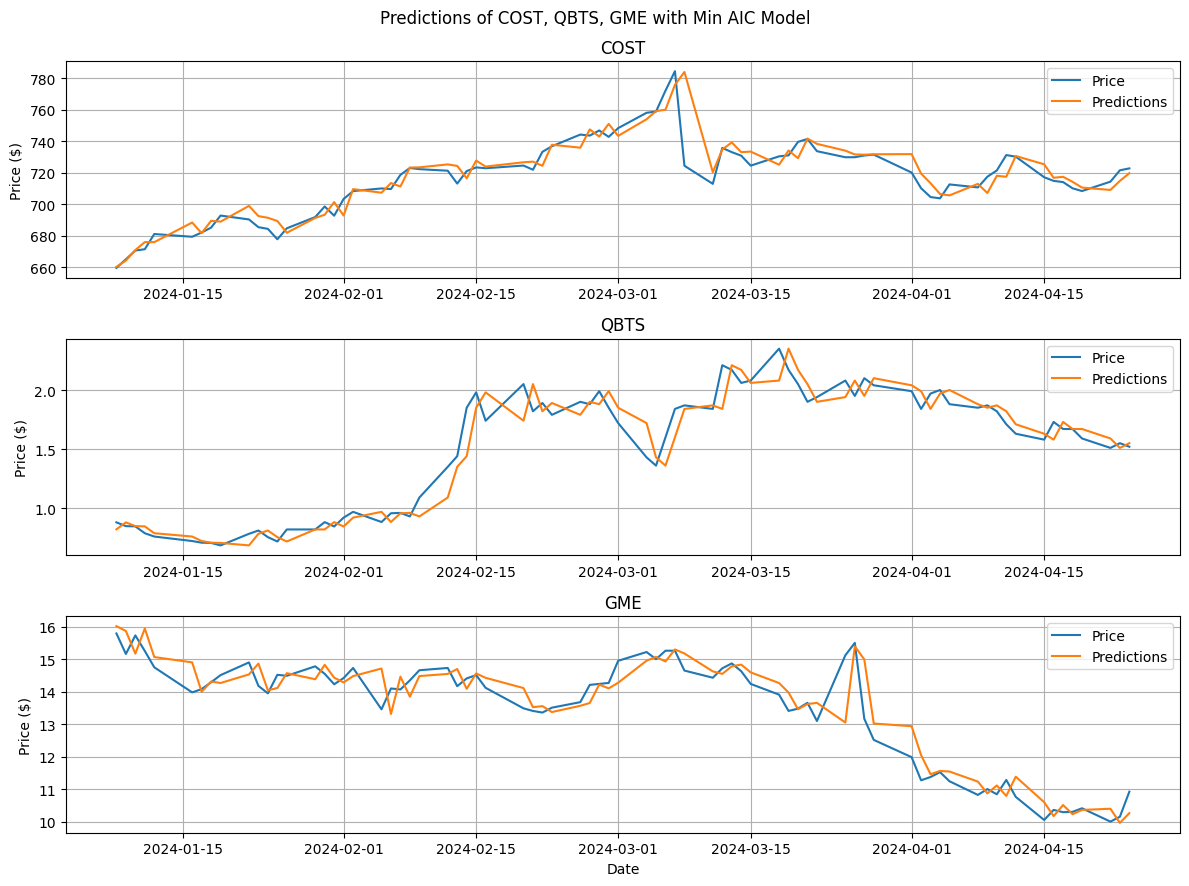

In [23]:
plot_prices(
    train_data,
    ['price', 'prediction'],
    ['Price', 'Predictions'],
    f'Predictions of {", ".join(dfs.keys())} with Min AIC Model'
)

### Alternative: Use autoarima to find optimal model

In [24]:
auto_models = {}

for ticker in tickers:
    auto_models[ticker] = auto_arima(train_data[ticker]['price'], start_p=0, start_q=0, seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=548.076, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=550.029, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=549.956, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=546.662, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=548.041, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.098 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-84.530, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-82.644, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-82.638, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-86.218, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-80.777, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.151 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=123.033, Time=0.01 sec
 A

huh

### Rolling Forecasts

In [29]:
for ticker in tickers:
    ticker_forecasts = []
    
    for i, date in enumerate(test_data[ticker].index):
        # update training data with new data point
        new_train_data = pd.concat([train_data[ticker]['price'], test_data[ticker]['price'].iloc[:i]])
        model = ARIMA(new_train_data, order=optimal_orders[ticker]['Min AIC Model'])
        model_fit = model.fit()
        forecast = model_fit.forecast()
        ticker_forecasts.append(float(forecast))
    
    test_data[ticker]['forecasts'] = ticker_forecasts
        

c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Yang\Documents\Projects\funance_blog\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Predicti

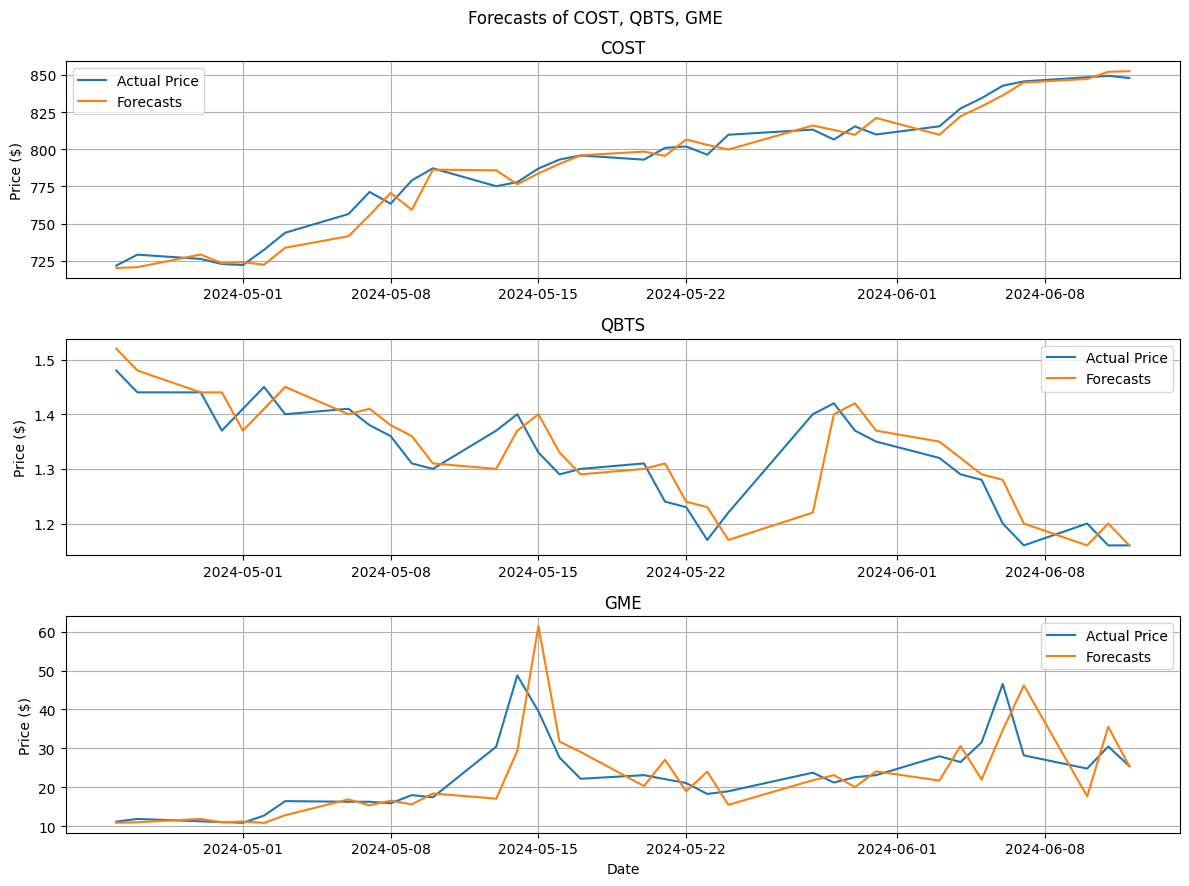

In [30]:
plot_prices(
    test_data,
    ['price', 'forecasts'],
    ['Actual Price', 'Forecasts'],
    f'Forecasts of {", ".join(dfs.keys())}'
)

### Forecast Evaluation

In [31]:
# residuals
for ticker in tickers:
    test_data[ticker]['residuals'] = test_data[ticker]['price'] - test_data[ticker]['forecasts']

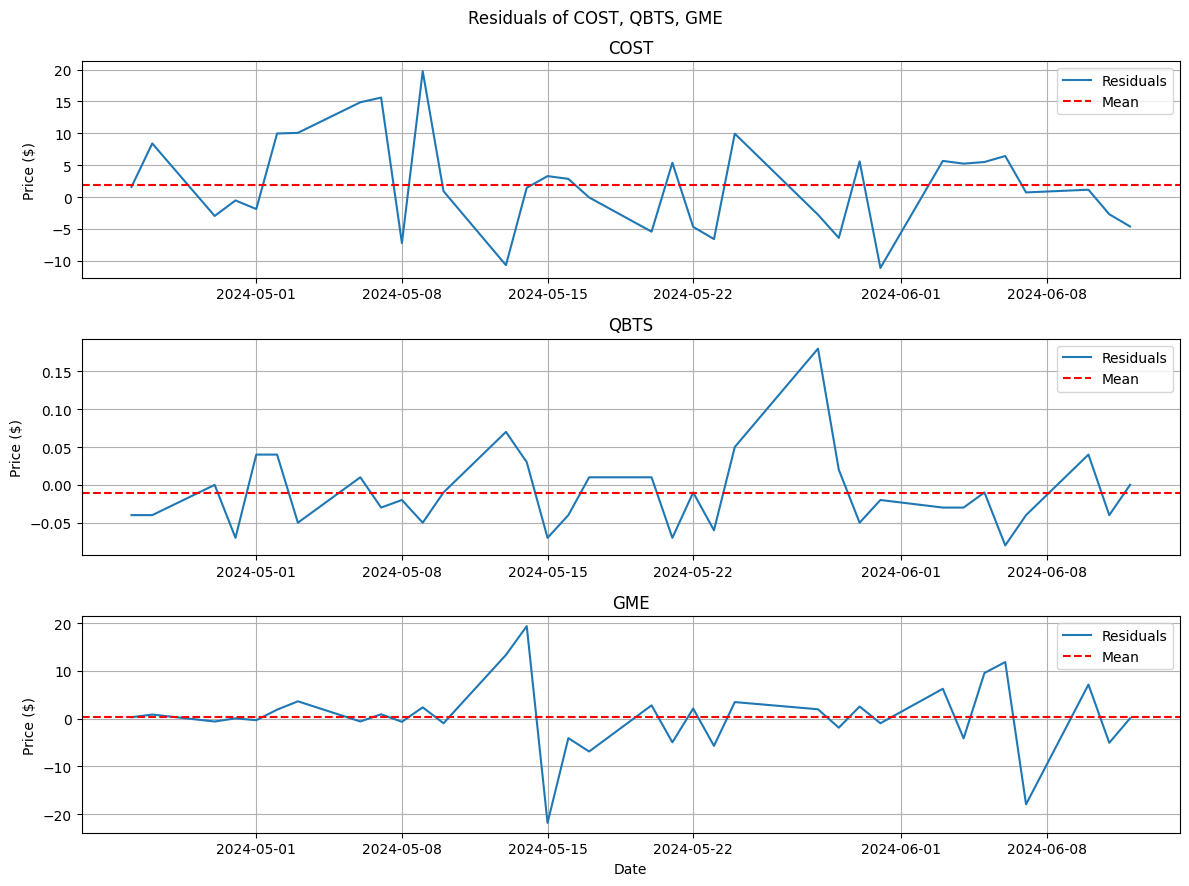

In [32]:
plot_prices(
    test_data,
    ['residuals'],
    ['Residuals'],
    f'Residuals of {", ".join(dfs.keys())}',
    True
)

In [33]:
# Mean absolute percent error
print(f'Mean Absolute Error:')

for ticker in tickers:
    mae = np.mean(np.abs(test_data[ticker]['residuals']/test_data[ticker]['price']))
    
    print(f'{ticker}: {np.round(mae, 4)*100}%')

Mean Absolute Error:
COST: 0.76%
QBTS: 3.04%
GME: 17.69%


In [34]:
# root mean squared error
print(f'Root Mean Squared Error:')

for ticker in tickers:
    rmse = np.sqrt(np.mean(test_data[ticker]['residuals']**2))
    
    print(f'{ticker}: {np.round(rmse, 4)}')

Root Mean Squared Error:
COST: 7.5121
QBTS: 0.0515
GME: 7.4858


### Day Trading Simulation

In [35]:
INITIAL_INVESTMENT = 100

In [36]:
# simulation plot
def plot_simulation(data: dict, transactions: dict, title: str) -> None:
    fig, axs = plt.subplots(len(data), 1, figsize=(12, 3*len(data)))
    
    for i, (ticker, df) in enumerate(data.items()):
        axs[i].plot(df['price'])
        axs[i].grid()
        
        current_val = transactions[ticker][-1]['value']
        returns = (current_val - INITIAL_INVESTMENT) / INITIAL_INVESTMENT
        text = (
            f'Current Value: ${np.round(current_val, 2)}\n'
            f'Returns: {np.round(returns*100, 2)}%'
        )
        axs[i].set_title(text)
        
        # vertical lines for transactions
        y_limits = [df['price'].min(), df['price'].max()]
        for n in range(0, len(transactions[ticker])-1, 2):
            axs[i].axvline(transactions[ticker][n]['date'], color='r' , linestyle='--')
            axs[i].axvline(transactions[ticker][n+1]['date'], color='g' , linestyle='--')
            
            shade_color = 'green' if transactions[ticker][n+1]['price'] > transactions[ticker][n]['price'] else 'red'
            axs[i].fill_betweenx(y_limits, transactions[ticker][n]['date'], transactions[ticker][n+1]['date'], color=shade_color, alpha=0.1)
            
        # legend
        custom_labels = [f'{ticker} Price', 'Buy Transaction', 'Sell Transaction']
        axs[i].legend(custom_labels)
        
    fig.suptitle(title)
    fig.tight_layout()

#### 1. Buying at the start and holding till the end

In [37]:
trans1 = {ticker: [] for ticker in tickers}

for ticker in tickers:
    trans1[ticker].append({
        'date': test_data[ticker].index[0],
        'price': test_data[ticker]['price'].iloc[0],
        'action': 'buy',
        'value': INITIAL_INVESTMENT
    })
    
    trans1[ticker].append({
        'date': test_data[ticker].index[-1],
        'price': test_data[ticker]['price'].iloc[-1],
        'action': 'sell',
        'value':  INITIAL_INVESTMENT * test_data[ticker]['price'].iloc[-1] / test_data[ticker]['price'].iloc[0]
    })


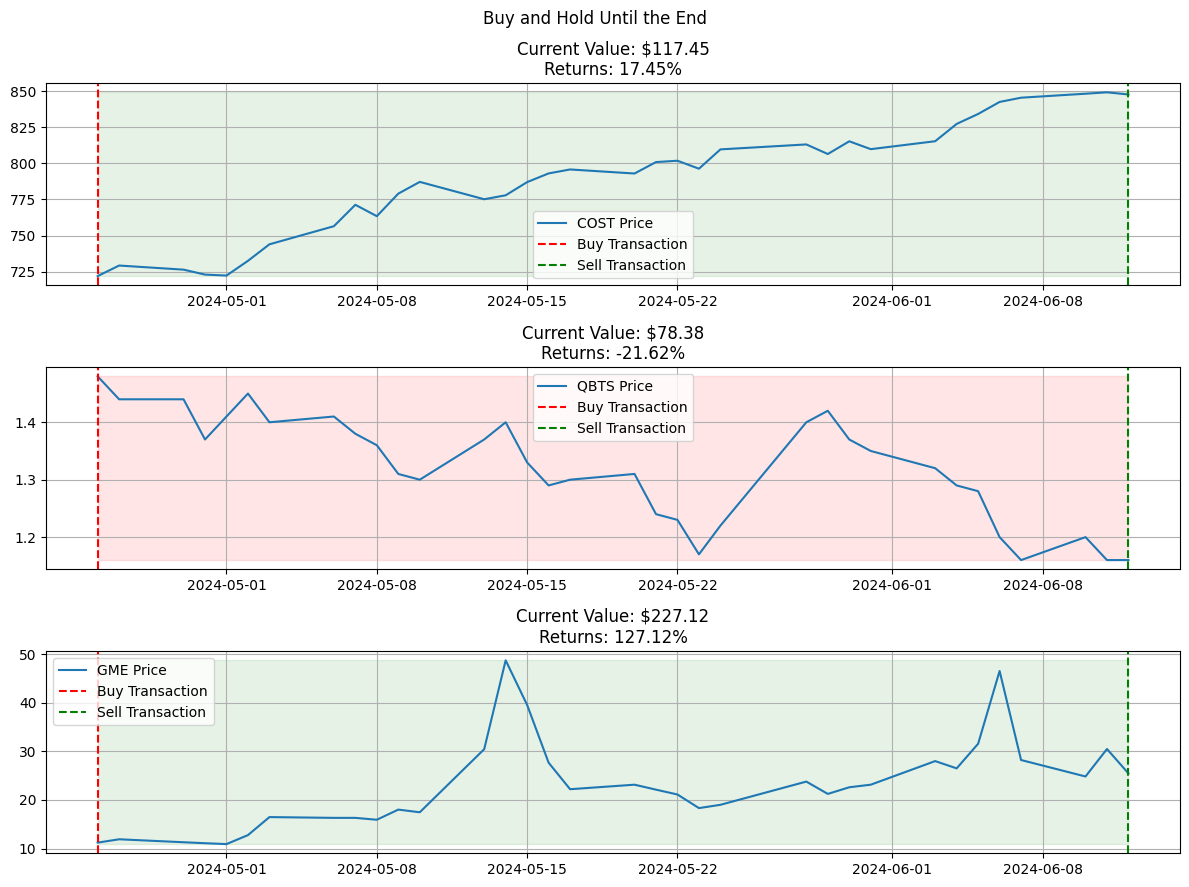

In [38]:
plot_simulation(test_data, trans1, 'Buy and Hold Until the End')

#### 2 Buying after stonks go up, selling after stocks go down

In [39]:
trans2 = {ticker: [] for ticker in tickers}

for ticker in tickers:
    for i in range(1, len(test_data[ticker])-1):
        # buy if price today is higher than yesterday
        if test_data[ticker]['price'].iloc[i] > test_data[ticker]['price'].iloc[i-1] and (trans2[ticker]==[] or trans2[ticker][-1]['action']=='sell'):
            trans2[ticker].append({
                'date': test_data[ticker].index[i],
                'price': test_data[ticker]['price'].iloc[i],
                'action': 'buy',
                'value': INITIAL_INVESTMENT if len(trans2[ticker])==0 else trans2[ticker][-1]['value']
            })
            
        # sell if price today is lower than yesterday and already owns the stock
        elif test_data[ticker]['price'].iloc[i] < test_data[ticker]['price'].iloc[i-1] and len(trans2[ticker])>0:
            if trans2[ticker][-1]['action'] == 'buy':
                returns = (test_data[ticker]['price'].iloc[i] - trans2[ticker][-1]['price']) / trans2[ticker][-1]['price']
                
                trans2[ticker].append({
                    'date': test_data[ticker].index[i],
                    'price': test_data[ticker]['price'].iloc[i],
                    'action': 'sell',
                    'value': (returns+1) * trans2[ticker][-1]['value']
                })
            
        # sell on last day
        elif i == len(test_data[ticker])-1 and trans2[ticker][-1]['action'] == 'buy':
            returns = (test_data[ticker]['price'].iloc[i] - trans2[ticker][-1]['price']) / trans2[ticker][-1]['price']
            
            trans2[ticker].append({
                'date': test_data[ticker].index[i],
                'price': test_data[ticker]['price'].iloc[i],
                'action': 'sell',
                'value': (returns+1) * trans2[ticker][-1]['value']
            })

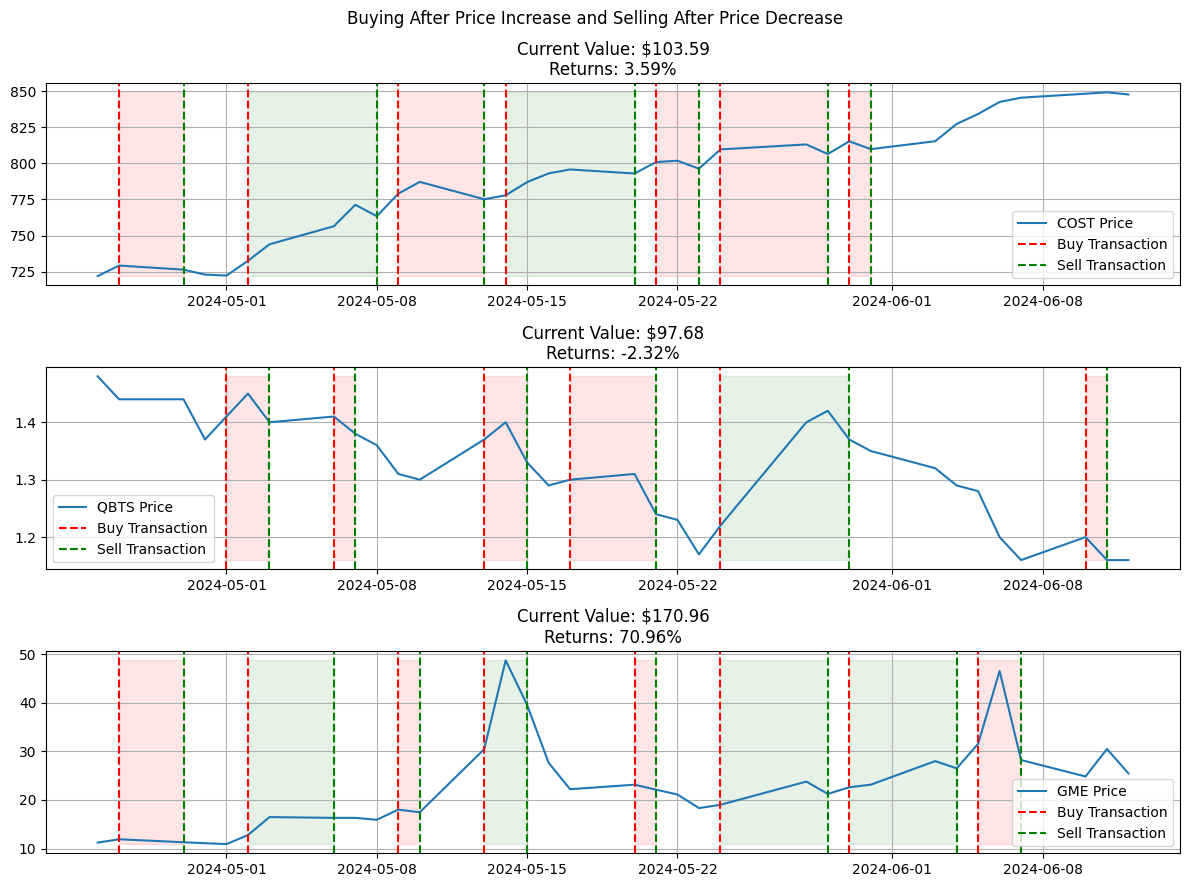

In [40]:
plot_simulation(test_data, trans2, 'Buying After Price Increase and Selling After Price Decrease')

#### 3 Buying if the stock goes up, selling the day after

In [41]:
trans3 = {ticker: [] for ticker in tickers}

for ticker in tickers:
    for i in range(1, len(test_data[ticker])-1):
        # buy if price today is higher than yesterday
        if test_data[ticker]['price'].iloc[i] > test_data[ticker]['price'].iloc[i-1] and (trans3[ticker]==[] or trans3[ticker][-1]['action']=='sell'):
            trans3[ticker].append({
                'date': test_data[ticker].index[i],
                'price': test_data[ticker]['price'].iloc[i],
                'action': 'buy',
                'value': INITIAL_INVESTMENT if len(trans3[ticker])==0 else trans3[ticker][-1]['value']
            })
            
        # sell next day
        elif len(trans3[ticker]) > 0 and trans3[ticker][-1]['action'] == 'buy':
            returns = (test_data[ticker]['price'].iloc[i] - trans3[ticker][-1]['price']) / trans3[ticker][-1]['price']
            
            trans3[ticker].append({
                'date': test_data[ticker].index[i],
                'price': test_data[ticker]['price'].iloc[i],
                'action': 'sell',
                'value': (returns+1) * trans3[ticker][-1]['value']
            })
            
        # sell on last day
        elif i == len(test_data[ticker])-1 and trans3[ticker][-1]['action'] == 'buy':
            returns = (test_data[ticker]['price'].iloc[i] - trans3[ticker][-1]['price']) / trans3[ticker][-1]['price']
            
            trans3[ticker].append({
                'date': test_data[ticker].index[i],
                'price': test_data[ticker]['price'].iloc[i],
                'action': 'sell',
                'value': (returns+1) * trans3[ticker][-1]['value']
            })

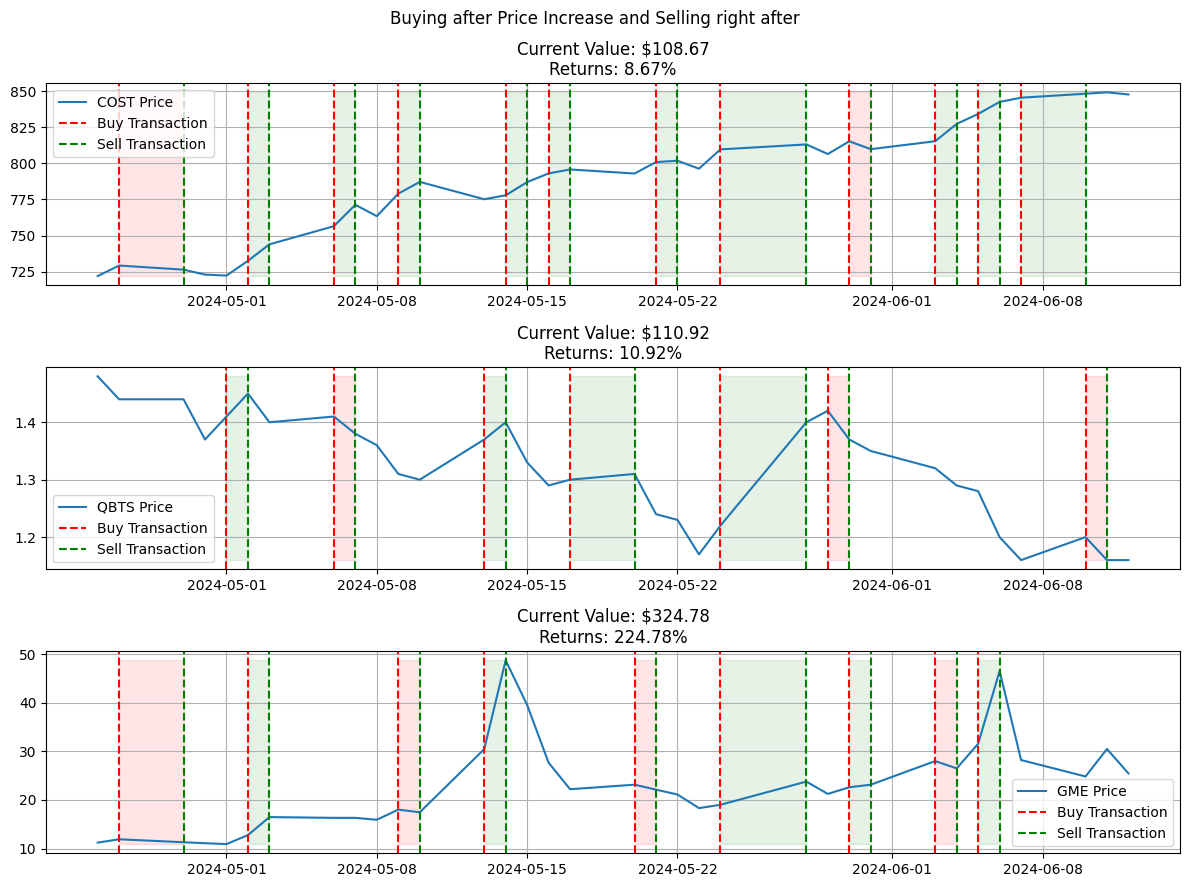

In [42]:
plot_simulation(test_data, trans3, 'Buying after Price Increase and Selling right after')

#### 4 ARIMA Models